<h1 style="text-align:center;">ESCUELA POLITÉCNICA NACIONAL</h1>
<h2 style="text-align:center;">FACULTAD DE INGENIERÍA DE SISTEMAS</h2>
<h3 style="text-align:center;">INGENIERÍA DE COMPUTACIÓN</h3>

**PERÍODO ACADÉMICO:** 2025-B

**ASIGNATURA:** ICCD412 Métodos Numéricos  

**GRUPO:** GR2  

**TIPO DE INSTRUMENTO:** Proyecto sobre calidad de aire en Quito 

**ALUMNOS:** Guerra Melissa, Velastegui Joel

## LIBRERÍAS IMPLEMENTADAS

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# IMPLEMENTACIÓN

# DEFINICIÓN DE FUNCIONES
## PREPROCESAMIENTO
Son funciones encargadas de la carga, limpieza e imputación de datos. Se aplica un criterio físico para la Radiación Solar (RS), limitando la interpolación a las horas diurnas.

In [16]:
def procesar_dataset_aire(
    ruta_archivo: str,
    hora_inicio_sol: int = 6,
    hora_fin_sol: int = 18,
    variables_interes: list = None,
    nombre_salida: str = "datos_interpolados_centro"
) -> pd.DataFrame:
    """
    Carga y procesa datos de calidad del aire, aplicando interpolación lineal.
    """
    # 1. Lectura y configuración del índice temporal
    df = pd.read_excel(ruta_archivo)
    df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
    df = df.sort_values("Fecha").set_index("Fecha")

    # 2. Selección de variables
    if variables_interes is None:
        variables_interes = ["CO", "NO2", "PM2.5", "VEL", "TMP", "RS"]
    
    # 3. Separación de variables: Continuas vs. Cíclicas (Radiación)
    vars_continuas = [v for v in variables_interes if v != "RS"]
    
    # Imputación lineal para variables continuas
    if vars_continuas:
        df[vars_continuas] = df[vars_continuas].interpolate(
            method="time", 
            limit_direction="both"
        )

    # 4. Tratamiento específico para Radiación Solar (RS)
    if "RS" in variables_interes:
        horas = df.index.hour
        mask_dia = (horas >= hora_inicio_sol) & (horas <= hora_fin_sol)
        
        # Interpolamos solo de día
        df.loc[mask_dia, "RS"] = df.loc[mask_dia, "RS"].interpolate(
            method="time", limit_direction="both"
        )
        # De noche asumimos 0 o mantenemos nulos tratados
        df["RS"] = df["RS"].fillna(0)

    # 5. Limpieza final y exportación
    df_final = df.dropna(subset=variables_interes)
    df_final.to_csv(f"{nombre_salida}.csv")
    print(f"Dataset procesado guardado como: {nombre_salida}.csv")

    return df_final

In [17]:
# Ejecución del preprocesamiento
df_base = procesar_dataset_aire(
    ruta_archivo="ProyMetodos_DatosCentro.xlsx",
    nombre_salida="datos_interpolados_centro"
)

# Verificación rápida
print(f"Dimensiones del dataset: {df_base.shape}")
df_base.head()

Dataset procesado guardado como: datos_interpolados_centro.csv
Dimensiones del dataset: (18285, 7)


,CO,NO2,PM2.5,VEL,DIR,TMP,RS
Fecha,,,,,,,
2023-10-01 00:00:00,0.611,33.25,9.41,1.11,267.72,13.13,0.0
2023-10-01 01:00:00,0.549,31.67,9.52,1.61,275.16,12.61,0.0
2023-10-01 02:00:00,0.368,20.47,6.12,1.83,274.40,12.06,0.0
2023-10-01 03:00:00,0.286,14.05,3.22,1.95,273.62,11.87,0.0
2023-10-01 04:00:00,0.315,18.22,4.29,2.08,281.30,11.43,0.0


In [29]:
def spline_cubico_natural(x, y, x_eval):
    n = len(x)

    if n < 2:
        return y

    if n == 2:
        return np.interp(x_eval, x, y)

    h = np.diff(x)

    A = np.zeros((n-2, n-2))
    b = np.zeros(n-2)

    for i in range(1, n-1):
        if i-2 >= 0:
            A[i-1, i-2] = h[i-2]
        A[i-1, i-1] = 2 * (h[i-2] + h[i-1])
        if i < n-2:
            A[i-1, i] = h[i-1]

        b[i-1] = 6 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])

    m = np.zeros(n)

    try:
        m[1:n-1] = np.linalg.solve(A, b)
    except:
        m[:] = 0

    def evaluar(z):
        if z <= x[0]:
            return y[0]
        if z >= x[-1]:
            return y[-1]

        i = np.searchsorted(x, z) - 1
        hi = h[i]

        return (
            m[i] * (x[i+1] - z)**3 / (6 * hi)
            + m[i+1] * (z - x[i])**3 / (6 * hi)
            + (y[i] / hi - m[i] * hi / 6) * (x[i+1] - z)
            + (y[i+1] / hi - m[i+1] * hi / 6) * (z - x[i])
        )

    return np.array([evaluar(z) for z in x_eval])


def aplicar_spline(df, variables, hora_inicio=6, hora_fin=18):
    df_out = df.copy()
    x = np.arange(len(df_out))
    horas = df_out.index.hour
    es_dia = (horas >= hora_inicio) & (horas <= hora_fin)

    for var in variables:
        y = df_out[var].values.astype(float)

        if np.isnan(y).sum() > 0:
            continue

        if var == "RS":
            y_suave = y.copy()
            i = 0
            while i < len(y):
                if not es_dia[i]:
                    i += 1
                    continue
                ini = i
                while i < len(y) and es_dia[i]:
                    i += 1
                fin = i
                if fin - ini >= 4:
                    y_suave[ini:fin] = spline_cubico_natural(
                        x[ini:fin], y[ini:fin], x[ini:fin]
                    )
            df_out[var + "_spline"] = y_suave
        else:
            df_out[var + "_spline"] = spline_cubico_natural(x, y, x)

    return df_out

In [30]:
def generar_modelo_minimos_cuadrados_lag(df_input: pd.DataFrame):
    """
    Entrena el modelo numérico aplicando Regresión Lineal Múltiple por Mínimos Cuadrados.
    Resuelve la ecuación normal: Beta = (X^T * X)^-1 * X^T * Y
    
    Returns:
        betas (np.array): Coeficientes calculados [Intercepto, CO, Lag, VEL, TMP, RS]
        r2 (float): Coeficiente de determinación del ajuste.
        rmse (float): Raíz del error cuadrático medio.
    """
    df = df_input.copy()
    
    # 1. Ingeniería de Características: Generación de Lag (t-1)
    if 'CO_lag1' not in df.columns:
        df['CO_lag1'] = df['CO'].shift(1)
    
    # 2. Definición de Matrices
    # Variables predictoras: CO(t), CO(t-1), VEL, TMP, RS
    predictors = ['CO', 'CO_lag1', 'VEL', 'TMP', 'RS']
    target = 'CO'
    
    # Limpieza de nulos por desplazamiento
    df_clean = df.dropna(subset=predictors + [target])
    
    # Construcción de Matriz X (con intercepto) y Vector Y
    X_vals = df_clean[predictors].values
    m = len(X_vals)
    ones = np.ones((m, 1))
    X_matriz = np.hstack((ones, X_vals)) # [1, CO, Lag, VEL, TMP, RS]
    Y_vector = df_clean[target].values
    
    # 3. Solución Numérica (Álgebra Lineal)
    XT = X_matriz.T
    try:
        XT_X = np.dot(XT, X_matriz)
        XT_Y = np.dot(XT, Y_vector)
        betas = np.linalg.solve(XT_X, XT_Y)
    except np.linalg.LinAlgError:
        print("Error: Singularidad matricial.")
        return None

    # 4. Cálculo de Métricas de Ajuste
    Y_est = np.dot(X_matriz, betas)
    
    # RMSE
    mse = np.mean((Y_vector - Y_est)**2)
    rmse = np.sqrt(mse)
    
    # R2
    ss_res = np.sum((Y_vector - Y_est)**2)
    ss_tot = np.sum((Y_vector - np.mean(Y_vector))**2)
    r2 = 1 - (ss_res / ss_tot)
    
    return betas, r2, rmse

## MODELADO Y VISUALIZACIÓN
Se generan modelos de regresión múltiple con componentes autoregresivos (lags) y funciones para validar visualmente los resultados.

In [31]:

# CONSTANTES

BETAS_MODELO = np.array([0.21800, 0.99544, -0.28656, -0.00791, -0.00144, -0.00006])
LIMITE_VERDE = 5.0
LIMITE_AMARILLO = 10.0

# FUNCIONES DE PROCESAMIENTO (Igual que antes)

def cargar_datos_excel(ruta_archivo: str) -> pd.DataFrame:
    df = pd.read_excel(ruta_archivo)
    cols = df.columns.values
    if len(cols) >= 5:
        df.rename(columns={cols[0]:'Fecha', cols[1]:'CO', cols[2]:'VEL', cols[3]:'TMP', cols[4]:'RS'}, inplace=True)
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values('Fecha').set_index('Fecha')
    return df

def predecir_con_modelo(df_input: pd.DataFrame, betas: np.array) -> pd.DataFrame:
    df = df_input.copy()
    if 'CO_lag1' not in df.columns: df['CO_lag1'] = df['CO'].shift(1)
    
    prediccion = betas[0] + betas[1]*df['CO'] + betas[2]*df['CO_lag1'] + \
                 betas[3]*df['VEL'] + betas[4]*df['TMP'] + betas[5]*df['RS']
    
    df['Prediccion_CO'] = prediccion.clip(lower=0)
    return df.dropna()

def clasificar_riesgo(val: float) -> str:
    if val <= LIMITE_VERDE: return "Verde (Buena)"
    if val <= LIMITE_AMARILLO: return "Amarillo (Moderada)"
    return "Naranja (Dañina)"


# FUNCIONES DE GRAFICACION (CORREGIDAS: AHORA CON VALIDACIÓN REAL)

def generar_trilogia_graficas(df: pd.DataFrame):
    print("Generando graficas de validacion...")
    
    # --- GRAFICA 1: ZOOM DIARIO (Detalle Picos) ---
    dia_zoom = '2025-11-03' 
    try:
        subset = df.loc[dia_zoom]
        plt.figure(figsize=(12, 6))
        
        plt.fill_between(subset.index.hour, subset['Prediccion_CO'], color='skyblue', alpha=0.4)
        plt.plot(subset.index.hour, subset['Prediccion_CO'], 'b-o', label='Modelo Predictivo', linewidth=2.5)
        plt.plot(subset.index.hour, subset['CO'].shift(-1), 'k--', label='Dato Real', alpha=0.5) # AQUI ESTA EL REAL
        
        # Sombras horas pico
        plt.axvspan(7, 9, color='red', alpha=0.1, label='Pico Mañana')
        plt.axvspan(17, 19, color='orange', alpha=0.1, label='Pico Tarde')

        plt.title(f'Nivel 1: Zoom Detallado ({dia_zoom}) - Real vs Modelo', fontsize=14)
        plt.xlabel('Hora del Dia')
        plt.ylabel('CO [mg/m3]')
        plt.xticks(range(0, 24))
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except KeyError: print(f"No hay datos para {dia_zoom}")

    # --- GRAFICA 2: CICLO QUINCENAL (Validacion) ---
    plt.figure(figsize=(14, 5))
    subset_sem = df.iloc[:336] # 14 dias
    
    # 1. Dato Real (Fondo, gris o negro transparente)
    plt.plot(subset_sem.index, subset_sem['CO'].shift(-1), 'k-', alpha=0.3, linewidth=1, label='Realidad (Validación)')
    
    # 2. Modelo (Frente, azul solido)
    plt.plot(subset_sem.index, subset_sem['Prediccion_CO'], 'b-', linewidth=1.5, label='Modelo Matemático')
    
    # Referencias
    plt.axhline(y=LIMITE_VERDE, color='green', linestyle='--', label='Limite Bueno')
    plt.fill_between(subset_sem.index, 0, LIMITE_VERDE, color='green', alpha=0.05)
    
    plt.title('Nivel 2: Validación de Tendencia (2 Semanas)', fontsize=14)
    plt.ylabel('CO [mg/m3]')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- GRAFICA 3: PANORAMA COMPLETO (Validacion) ---
    plt.figure(figsize=(14, 5))
    
    # 1. Dato Real (Fondo)
    plt.plot(df.index, df['CO'].shift(-1), 'k-', alpha=0.2, linewidth=0.5, label='Datos Reales')
    
    # 2. Modelo (Frente)
    plt.plot(df.index, df['Prediccion_CO'], 'b-', linewidth=1, alpha=0.8, label='Predicción Modelo')
    
    # Referencias
    plt.axhline(y=LIMITE_VERDE, color='green', linestyle='--', linewidth=2, label='Zona Segura')
    plt.axhline(y=LIMITE_AMARILLO, color='gold', linestyle='--', linewidth=2, label='Limite Moderado')
    
    plt.title('Nivel 3: Validación Robusta (Noviembre - Diciembre 2025)', fontsize=14)
    plt.ylabel('CO [mg/m3]')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

def generar_pronostico_7dias(df: pd.DataFrame):
    """
    Aqui NO ponemos el dato real, porque estamos simulando que es el futuro
    y 'no sabemos' qué va a pasar. Es la aplicación pura.
    """
    print("Generando Pronostico Operativo (Simulacion Futura)...")
    fecha_inicio = '2025-11-03 00:00:00'
    fecha_fin = '2025-11-09 23:00:00'
    try:
        subset = df.loc[fecha_inicio:fecha_fin]
        plt.figure(figsize=(14, 6))
        
        plt.plot(subset.index, subset['Prediccion_CO'], 'b-', linewidth=2.5, label='Pronostico Generado')
        plt.fill_between(subset.index, 0, subset['Prediccion_CO'], color='blue', alpha=0.05)
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A %d'))
        plt.title('Simulacion de Pronostico Operativo (Horizonte 7 Dias)', fontsize=14)
        plt.ylabel('CO [mg/m3]')
        plt.xlabel('Dia de la Semana')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    except: print("Error en fechas de pronostico")

## Ejecución del flujo principal del proyecto
En esta sección se orquestan todas las funciones definidas anteriormente.
1. Carga de datos.
2. Aplicación de Splines.
3. Generación del modelo matemático.
4. Reporte de resultados.

1.Iniciando procesamiento de datos...
Dataset procesado guardado como: datos_interpolados_centro.csv
 Tiempo de carga y limpieza: 1.2286 seg

2.Aplicando Splines Cúbicos (Cálculo Numérico)...
Tiempo de ejecución Splines: 76.5672 seg


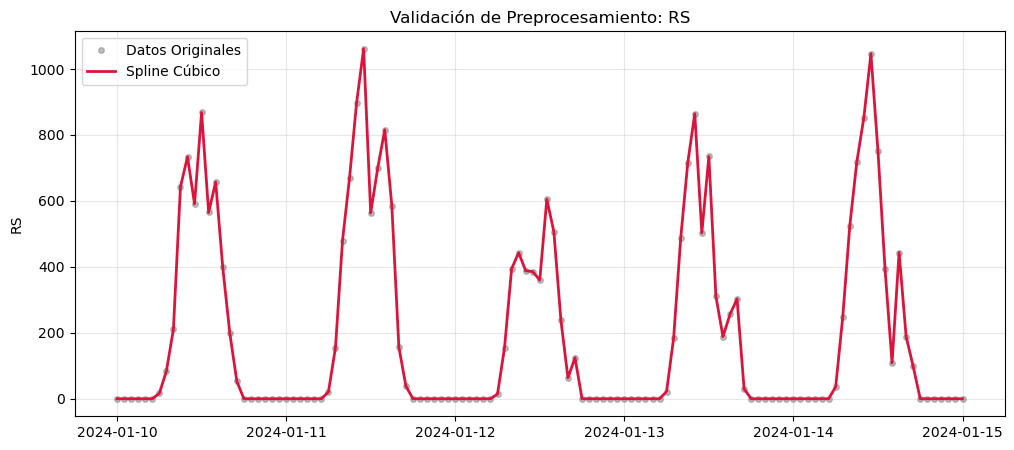


3.Calculando modelo con memoria histórica (Mínimos Cuadrados)...
Tiempo de entrenamiento del modelo: 0.0046 seg
------------------------------------------------------------
REPORTE FINAL
------------------------------------------------------------
R² (Coef. Determinación): 0.6596
RMSE (Error cuadrático):  0.2018
------------------------------------------------------------
Coeficientes calculados (Beta):
  Intercepto  : +0.21897
  CO(t)       : +0.99485
  CO(t-1)     : -0.28678
  VEL         : -0.00791
  TMP         : -0.00150
  RS          : -0.00006


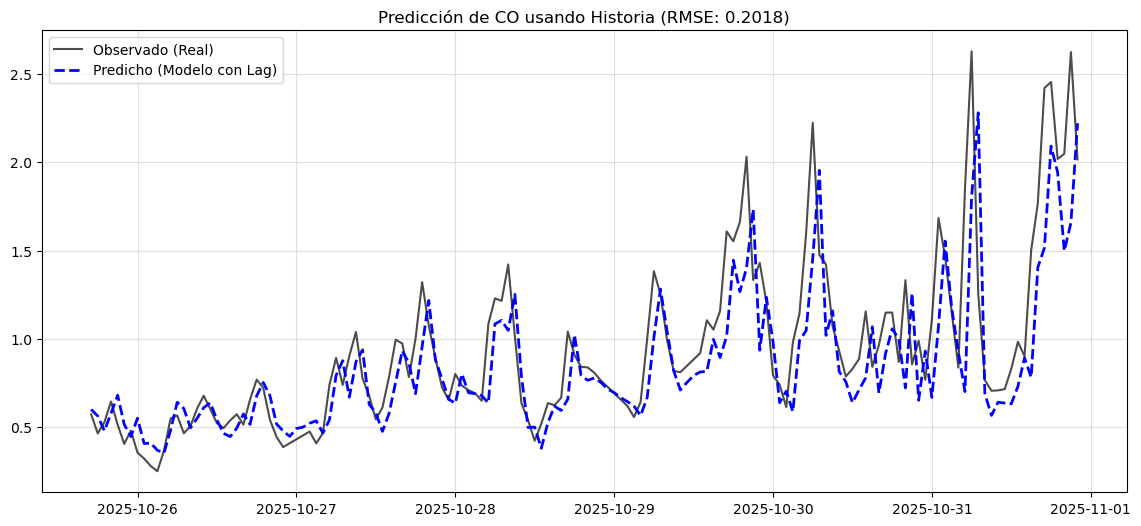


Tiempo TOTAL de ejecución del script: 78.0377 seg


In [34]:
# --- INICIO DEL CRONÓMETRO TOTAL ---
tiempo_inicio_total = time.time()

# --- PASO 1: CARGA ---
archivo_entrada = "ProyMetodos_DatosCentro.xlsx" 

try:
    print("1.Iniciando procesamiento de datos...")
    t_inicio = time.time()
    df_clean = procesar_dataset_aire(ruta_archivo=archivo_entrada)
    t_fin = time.time()
    print(f" Tiempo de carga y limpieza: {t_fin - t_inicio:.4f} seg")
    
    # --- PASO 2: SPLINES ---
    print("\n2.Aplicando Splines Cúbicos (Cálculo Numérico)...")
    t_inicio = time.time()
    
    vars_a_suavizar = ["CO", "NO2", "PM2.5", "VEL", "TMP", "RS"]
    df_suavizado = aplicar_spline(df_clean, vars_a_suavizar)
    
    t_fin = time.time()
    print(f"Tiempo de ejecución Splines: {t_fin - t_inicio:.4f} seg")
    
    # Validación visual
    graficar_comparacion_metodos(df_suavizado, variable="RS", fecha_inicio="2024-01-10", dias=5)

    # --- PASO 3: MODELADO CON LAG ---
    print("\n3.Calculando modelo con memoria histórica (Mínimos Cuadrados)...")
    t_inicio = time.time()
    
    betas_calculados, r2_score, rmse_score = generar_modelo_minimos_cuadrados_lag(df_suavizado)
    
    t_fin = time.time()
    print(f"Tiempo de entrenamiento del modelo: {t_fin - t_inicio:.4f} seg")

    # --- PASO 4: RESULTADOS ---
    print("-" * 60)
    print(f"REPORTE FINAL")
    print("-" * 60)
    print(f"R² (Coef. Determinación): {r2:.4f}")
    print(f"RMSE (Error cuadrático):  {rmse:.4f}")
    print("-" * 60)
    
    names = ['Intercepto', 'CO(t)', 'CO(t-1)', 'VEL', 'TMP', 'RS']
    print("Coeficientes calculados (Beta):")
    for n, b in zip(names, betas):
        print(f"  {n:<12}: {b:+.5f}")
        
    visualizar_prediccion(fechas_val, Y_real, Y_est, rmse)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{archivo_entrada}'.")
except Exception as e:
    print(f"Error inesperado: {e}")

# --- FIN DEL CRONÓMETRO TOTAL ---
tiempo_fin_total = time.time()
print(f"\nTiempo TOTAL de ejecución del script: {tiempo_fin_total - tiempo_inicio_total:.4f} seg")

## PREDICCIÓN Y ANÁLISIS DE RESULTADOS

In [35]:
def generar_trilogia_graficas(df: pd.DataFrame):
    print("Generando graficas de validacion...")
    
    # --- GRAFICA 1: ZOOM DIARIO (Detalle Picos) ---
    dia_zoom = '2025-11-03'  # Lunes
    try:
        subset_dia = df.loc[dia_zoom]
        plt.figure(figsize=(12, 6))
        
        # Grafica Real vs Modelo
        plt.plot(subset_dia.index.hour,
                 subset_dia['CO'].shift(-1),
                 'k-o', label='Dato Real', alpha=0.5)
        plt.plot(subset_dia.index.hour,
                 subset_dia['Prediccion_CO'],
                 'b--x', label='Prediccion Modelo', linewidth=2)
        
        # ZONAS DE INTERES (Picos de Trafico)
        plt.axvspan(7, 9, color='red', alpha=0.1,
                    label='Pico Mañana (07:00 - 09:00)')
        plt.axvspan(17, 19, color='orange', alpha=0.1,
                    label='Pico Tarde (17:00 - 19:00)')

        plt.title(f'Variación horaria del CO (Lunes {dia_zoom})')
        plt.xlabel('Hora del Dia (00:00 - 23:00)')
        plt.ylabel('Concentracion CO [mg/m3]')
        plt.xticks(range(0, 24))
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

    except KeyError:
        print(f"No hay datos para {dia_zoom}")

    # --- GRAFICA 2: TENDENCIA 2 SEMANAS ---
    plt.figure(figsize=(14, 5))
    subset_sem = df.iloc[:336]  # 14 dias
    
    plt.plot(subset_sem.index,
             subset_sem['CO'].shift(-1),
             'k-', alpha=0.3, linewidth=1,
             label='Realidad (Validación)')
    
    plt.plot(subset_sem.index,
             subset_sem['Prediccion_CO'],
             'b-', linewidth=1.5,
             label='Modelo Matemático')
    
    plt.axhline(y=LIMITE_VERDE,
                color='green', linestyle='--',
                label='Limite Bueno')
    plt.fill_between(subset_sem.index,
                     0, LIMITE_VERDE,
                     color='green', alpha=0.05)
    
    plt.title('Validación con las primeras dos semanas de Noviembre 2025', fontsize=14)
    plt.ylabel('CO [mg/m3]')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- GRAFICA 3: PANORAMA COMPLETO ---
    plt.figure(figsize=(14, 5))
    
    plt.plot(df.index,
             df['CO'].shift(-1),
             'k-', alpha=0.2, linewidth=0.5,
             label='Datos Reales')
    
    plt.plot(df.index,
             df['Prediccion_CO'],
             'b-', linewidth=1, alpha=0.8,
             label='Predicción Modelo')
    
    plt.axhline(y=LIMITE_VERDE,
                color='green', linestyle='--',
                linewidth=2, label='Zona Segura')
    plt.axhline(y=LIMITE_AMARILLO,
                color='gold', linestyle='--',
                linewidth=2, label='Limite Moderado')
    
    plt.title('Validación Robusta (Noviembre - Diciembre 2025)', fontsize=14)
    plt.ylabel('CO [mg/m3]')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()


Generando graficas de validacion...


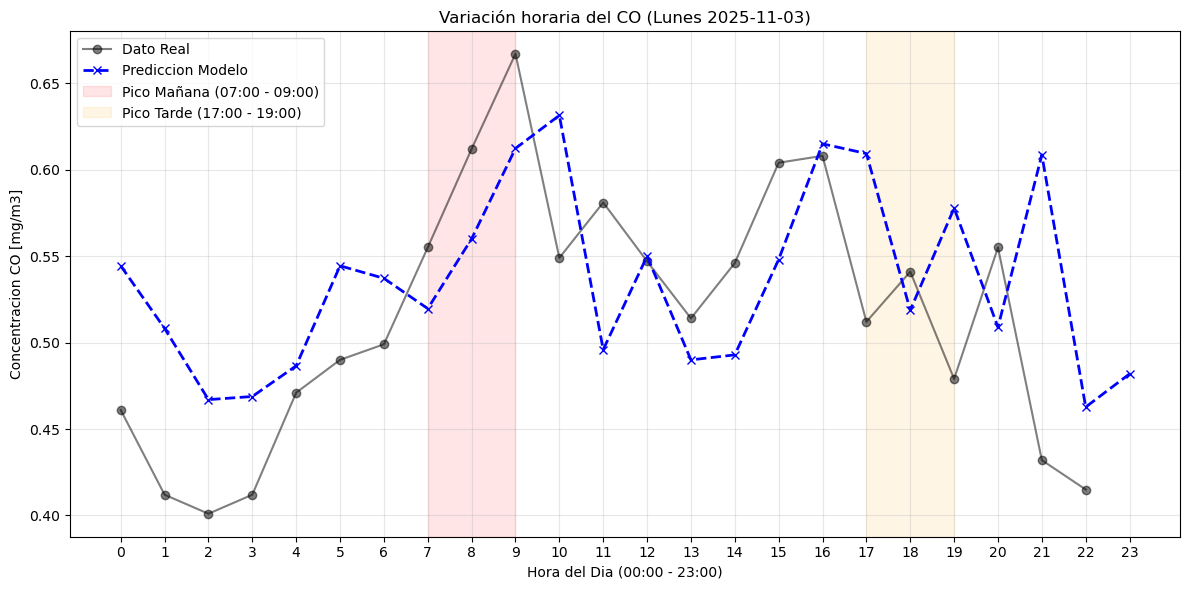

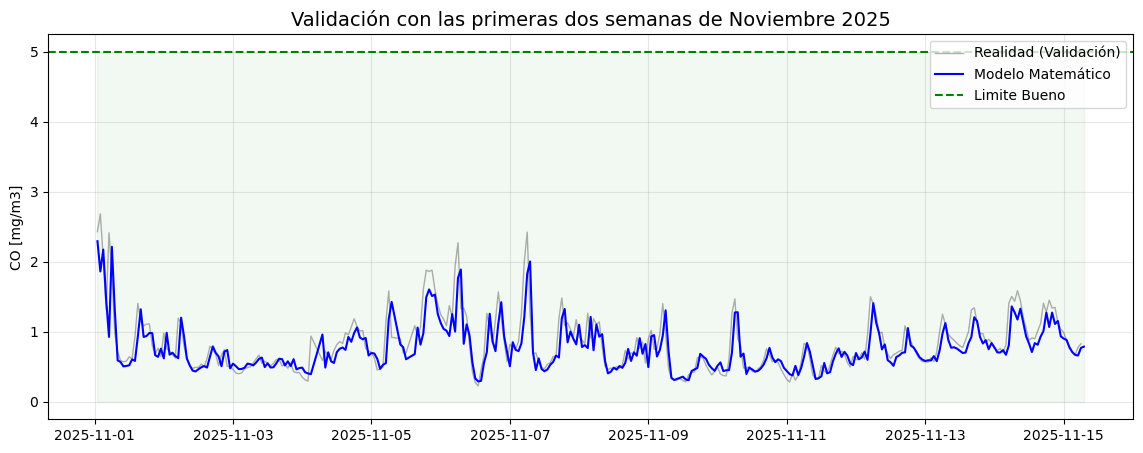

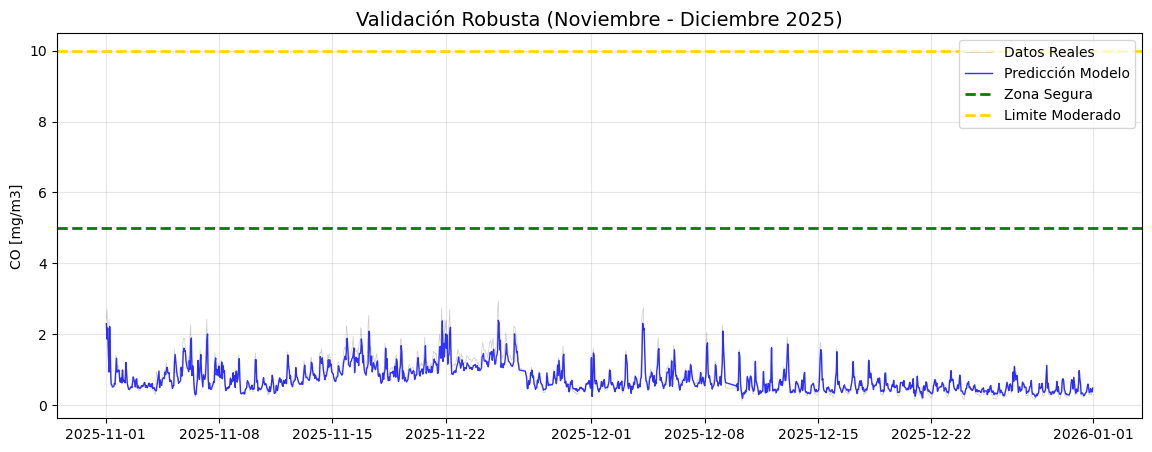

Generando Pronostico Operativo (Simulacion Futura)...


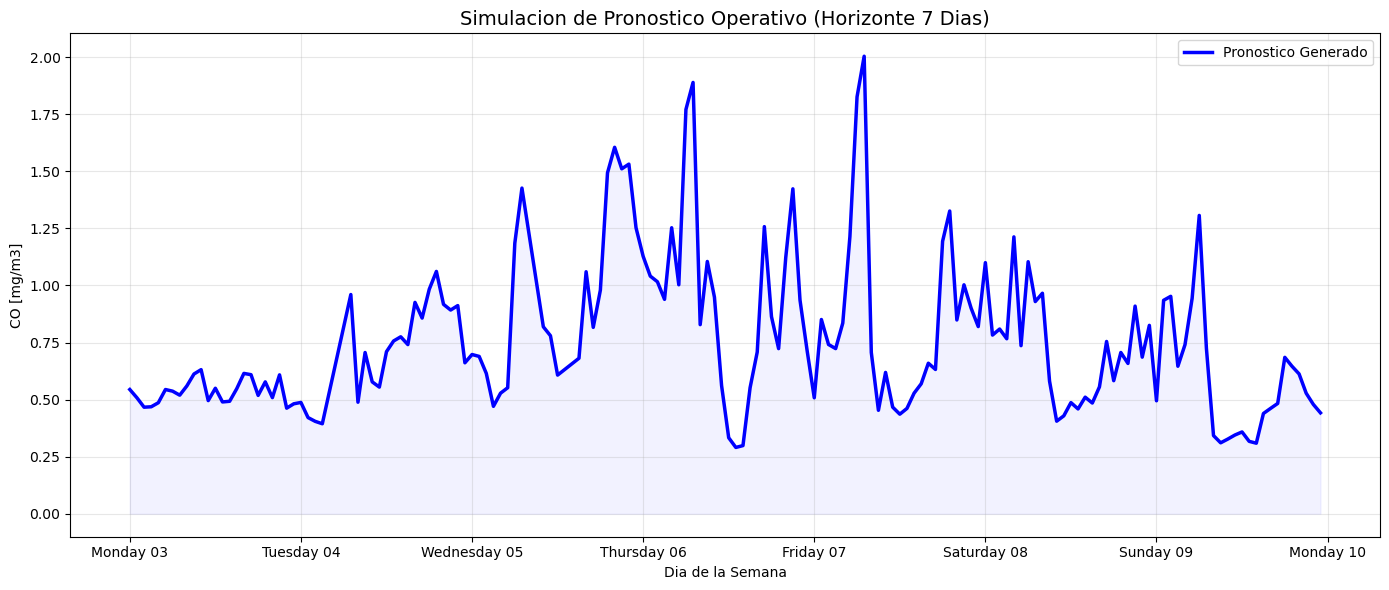


--- INFORME DE RIESGOS ---
Total horas analizadas: 1432
Categoria_ICA
Verde (Buena)    100.0
Name: proportion, dtype: float64


In [36]:
# 1. Cargar Datos
archivo = 'Datos_Implementacion.xlsx'
df_raw = cargar_datos_excel(archivo)

# 2. Ejecutar Modelo
df_final = predecir_con_modelo(df_raw, BETAS_MODELO)

# 3. Clasificar Riesgo
df_final['Categoria_ICA'] = df_final['Prediccion_CO'].apply(clasificar_riesgo)

# 4. Generar Visualizaciones
# Grafica 1: Dia Lunes (Zoom con sombreado rojo/naranja)
# Grafica 2: 15 Dias (Con limite verde)
# Grafica 3: Total (Con limites verde/amarillo)
generar_trilogia_graficas(df_final)

# Grafica 4: Pronostico Futuro (7 Dias)
generar_pronostico_7dias(df_final)

# 5. Reporte Estadistico
print("\n--- INFORME DE RIESGOS ---")
total = len(df_final)
print(f"Total horas analizadas: {total}")
conteo = df_final['Categoria_ICA'].value_counts(normalize=True) * 100
print(conteo)
